In [17]:
from typing import Optional

import seaborn as sns
import numpy as np
from data import load_amp, load_uke
import pandas as pd
import warnings
from sklearn.metrics import RocCurveDisplay
import statsmodels.formula.api as smf

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning import seed_everything

from vae import VariationAutoencoderModule, KullbackLeiblerLoss, WassersteinLoss

PDQ_COLUMNS = [
    "Mobility",
    "Daily living",
    "Emotion",
    "Stigmatization",
    "Social support",
    "Cognition",
    "Communication",
    "Bodily discomfort",
]
COVARIATES = ["Time since diagnosis", "Age", "Sex"]
EXTRA_COVARIATES = ["UPDRS I", "UPDRS II", "UPDRS III", "UPDRS IV", "MoCA"]
SEED = 41
THRESHOLD = 10.9

class AmpData(Dataset):
    def __init__(self, path, add_covariates: bool = True):
        super().__init__()
        X_amp, covariates_amp = load_amp(
            path,
            sample_one_measurement_per_subject=False,
        )
        X, y, extra_data = self.parse_data(X_amp, covariates_amp)
        
        included_predictions = (pd.isna(X[PDQ_COLUMNS]).sum(axis=1) <= 2) & (pd.isna(y[PDQ_COLUMNS]).sum(axis=1) <= 2)
        self.y = y[included_predictions][PDQ_COLUMNS].reset_index(drop=True).to_numpy(np.float32) / 100.0
        
        if add_covariates:
            self.X = X[included_predictions][PDQ_COLUMNS + COVARIATES + EXTRA_COVARIATES].copy()
            self.X["Time since diagnosis"] *= 10.0
            self.X["Sex"] *= 100.0
        else:
            self.X = X[included_predictions][PDQ_COLUMNS]
        self.X = self.X.reset_index(drop=True).fillna(-100).to_numpy(np.float32) / 100.0
        
        self.extra_data = extra_data[included_predictions].reset_index(drop=True)
        

    def __getitem__(self, index):
        return (self.X[index], self.y[index])

    def __len__(self):
        return len(self.X)

    @classmethod
    def cast_to_float(cls, data):
        for column in data.columns:
            data[column] = pd.to_numeric(data[column], errors="coerce")
        return data

    @classmethod
    def preprocess_covariates(cls, data):
        data = data.copy()
        data["Sex"] = data["Sex"].map({"Male": 0.0, "Female": 1.0})
        data = cls.cast_to_float(data)
        return data

    @classmethod
    def parse_data(cls, y, covariates):
        data = pd.concat(
            (y[["Participant", "Study", "Visit ID", *PDQ_COLUMNS,
            *EXTRA_COVARIATES]], covariates[COVARIATES]), axis=1
        ).dropna(thresh=4 + len(COVARIATES) + len(EXTRA_COVARIATES))
        data["Visit ID"] = data["Visit ID"].str[1:].astype(int)
        data = data[data["Study"] != "HBS"]

        X = []
        y = []
        extra_data = []

        for _, data in data.sort_values(
            ["Participant", "Visit ID"], ascending=True
        ).groupby(["Participant"]):
            for iloc, (_, row) in enumerate(data.iterrows()):
                if iloc > 0:
                    previous_row = data.iloc[iloc - 1]
                    previous_row = previous_row[PDQ_COLUMNS].to_list() + [
                        (row["Visit ID"] - previous_row["Visit ID"]) / 12.0
                    ]
                else:
                    previous_row = [np.nan] * (len(PDQ_COLUMNS) + 1)

                X.append(
                    previous_row + row[COVARIATES].to_list() + row[EXTRA_COVARIATES].to_list())
                y.append(row[PDQ_COLUMNS])
                extra_data.append([row["Study"]])

        return cls.preprocess_covariates(
            pd.DataFrame(X, columns=PDQ_COLUMNS +
                        ["Time since last visit"] + COVARIATES + EXTRA_COVARIATES)
        ), cls.cast_to_float(pd.DataFrame(y, columns=PDQ_COLUMNS).reset_index(drop=True)), pd.DataFrame(extra_data, columns=["Study"])

class PdqDataModule(L.LightningDataModule):
    def __init__(
        self,
        dataset: Dataset,
        ratio_var_dataset: float,
        batch_size: int,
    ):
        super().__init__()
        assert 0 < ratio_var_dataset <= 1

        self.data = dataset
        self.batch_size = batch_size

        if ratio_var_dataset < 1:
            self.val_start = int(len(self.data) * (1 - ratio_var_dataset))
        else:
            self.val_start = 0

    def train_dataloader(self):
        if self.val_start == 0:
            raise ValueError("Only the validation set is used.")
        return DataLoader(
            Subset(self.data, range(0, self.val_start)),
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=False,
            num_workers=8,
        )

    def val_dataloader(self):
        return DataLoader(
            Subset(self.data, range(self.val_start, len(self.data))),
            batch_size=self.batch_size,
            shuffle=False,
            drop_last=False,
            num_workers=4,
        )
        
class PdqLoss(torch.nn.Module):
    def __init__(self, threshold: Optional[float], *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        if threshold is not None:
            self.classification_layer = torch.nn.Linear(2, 1)
            self.threshold = threshold
        else:
            self.classification_layer = None
            self.threshold = None
        
    @property
    def n_values(self) -> int:
        return len(PDQ_COLUMNS) + len(EXTRA_COVARIATES) + len(COVARIATES)

    @property
    def last_layer_size(self) -> int:
        return 8

    def calculate_reconstruction(self, y_raw: torch.Tensor) -> torch.Tensor:
        return F.sigmoid(y_raw)

    def calculate_reconstruction_loss(self, y_true: torch.Tensor, y_pred: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        if not isinstance(y_true, torch.Tensor):
            (x_true, y_true) = y_true
        missing_values = ~torch.isnan(y_true) 
        
        BCE = F.binary_cross_entropy_with_logits(input=y_pred[missing_values], target=y_true[missing_values], reduction='mean')
        if self.classification_layer is not None:
            prediction_logits = self.classification_layer(z)[:, 0]
            x_true_mean = x_true[:, :y_true.shape[1]].mean(dim=1)
            y_true_mean = y_true.mean(dim=1)
            difference_with_nan = x_true_mean - y_true_mean
            known_values = ~torch.isnan(difference_with_nan)
    
            CLASSIFICATION_LOSS = F.binary_cross_entropy_with_logits(input=prediction_logits[known_values], target=torch.where(difference_with_nan[known_values] > self.threshold, torch.tensor([1.0]), torch.tensor([0.0])), reduction='mean')
            return BCE + CLASSIFICATION_LOSS
        else:
            return BCE
        
        #LOGC = -PdqLoss.sumlogC(y_pred[missing_values])
        # return BCE #+ LOGC

    @staticmethod
    def sumlogC(x, eps = 1e-5):
        x = torch.clamp(x, eps, 1.-eps) 
        mask = torch.abs(x - 0.5).ge(eps)
        far = torch.masked_select(x, mask)
        close = torch.masked_select(x, ~mask)
        far_values =  torch.log( (torch.log(1. - far) - torch.log(far)).div(1. - 2. * far) )
        close_values = torch.log(torch.tensor((2.))) + torch.log(1. + torch.pow( 1. - 2. * close, 2)/3. )
        return far_values.sum() + close_values.sum()

seed_everything(SEED, workers=True)
torch.use_deterministic_algorithms(True)

dataset = AmpData("/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/updrs_amp_all.csv")
data_module = PdqDataModule(dataset, 0.1, 256)

Seed set to 41


In [2]:
NAME = "vae_pdq"

reconstruction_loss = PdqLoss(threshold=THRESHOLD)
# generative_loss = KullbackLeiblerLoss(beta=1.0)
generative_loss = WassersteinLoss(reg_weight=10, kernel_type="imq", z_var=2.0)

model = VariationAutoencoderModule(
    reconstruction_loss,
    generative_loss,
    [8, 6, 2],
    patience=40,
    learning_rate=1e-3,
    dropout=0.05,
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename=NAME,
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min",
)
early_stopping = EarlyStopping(monitor="val_loss", patience=80, mode="min")
logger = TensorBoardLogger("logs", name=NAME)

# Initialize the PyTorch Lightning trainer
trainer = L.Trainer(
    max_epochs=2000, callbacks=[early_stopping], logger=logger, log_every_n_steps=6, deterministic=True
)

trainer.fit(model, data_module)

model = model.model

/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'reconstruction_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['reconstruction_loss'])`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params | Mode 
---------------------------------------------------------
0 | model | VariationalAutoencoder | 367    | train
---------------------------------------------------------
367       Trainable params
0         Non-trainable params
367       Total params
0.001     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 836: 100%|██████████| 7/7 [00:00<00:00, 15.39it/s, v_num=14]         


In [34]:
model = VariationAutoencoderModule.load_from_checkpoint(
   "/workspaces/de.uke.iam.parkinson.vae_longitudinal/conditional/logs/vae_pdq/version_14/checkpoints/epoch=836-step=5859.ckpt"
).model.eval()

/home/vscode/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'reconstruction_loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['reconstruction_loss'])`.


In [12]:
X_uke, covariates_uke, extra_data_uke, y_uke = load_uke(
    "/workspaces/de.uke.iam.parkinson.vae_longitudinal/data/pdq_uke_new.csv",
    PDQ_COLUMNS + EXTRA_COVARIATES,
)

X_uke = pd.concat(
    (
        X_uke,
        extra_data_uke[["Time since last test"]].rename(
            columns={"Time since last test": "Time since last visit"}
        ),
        covariates_uke[COVARIATES],
    ),
    axis=1,
)
full_measurements_uke = pd.isna(X_uke).sum(axis=1) < 4
X_uke = AmpData.preprocess_covariates(X_uke)[full_measurements_uke]
covariates_uke = covariates_uke[full_measurements_uke]
extra_data_uke = extra_data_uke[full_measurements_uke]
y_uke = y_uke[full_measurements_uke]

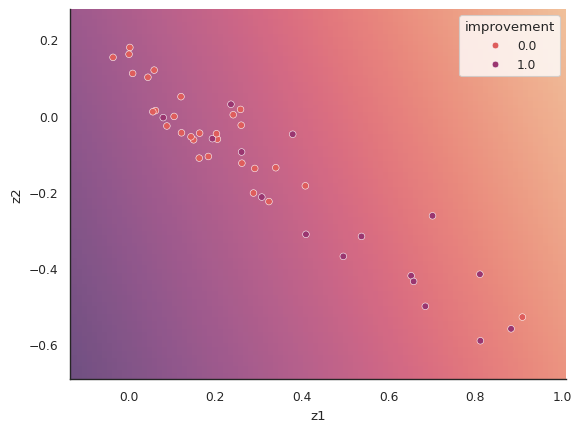

In [95]:
test_data = X_uke[PDQ_COLUMNS + COVARIATES + EXTRA_COVARIATES].copy()
test_data["Sex"] *= 100.0
test_data["Time since diagnosis"] *= 10.0
uke_data_tensor = torch.tensor((test_data.fillna(-100) / 100.0).astype(np.float32).to_numpy())

mu = model(uke_data_tensor, compute_loss=False).z_dist.loc
mu = pd.DataFrame(mu.detach().numpy(), columns=["z1", "z2"])
mu["improvement"] = (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float)

with sns.axes_style("white"):
    sns.set_context("paper")
    ax = sns.scatterplot(data=mu, x="z1", y="z2", hue="improvement", palette="flare")
    #ax.set_aspect("equal")
    
    min_value = min(mu[["z1", "z2"]].min())
    min_value -= 0.1 * abs(min_value)
    max_value = max(mu[["z1", "z2"]].max())
    max_value += 0.1 * abs(max_value)

    ax.set_xlim(min(mu["z1"]) - 0.1, max(mu["z1"]) + 0.1)
    ax.set_ylim(min(mu["z2"]) - 0.1, max(mu["z2"]) + 0.1)
    
    XX, YY = np.meshgrid(np.linspace(*ax.get_xlim(), 100), np.linspace(*ax.get_ylim(), 100))
    coordinates = np.stack((XX, YY), axis=-1).reshape((-1, 2))
    predictions = torch.sigmoid(model.reconstruction_loss.classification_layer(torch.tensor(coordinates, dtype=torch.float32))).detach().numpy().reshape((100, 100))
    ax.pcolormesh(XX, YY, predictions, shading="auto", alpha=0.8, zorder=-1, cmap="flare")
    
    print()
    sns.despine()

Optimization terminated successfully.
         Current function value: 0.449145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505234
         Iterations 6


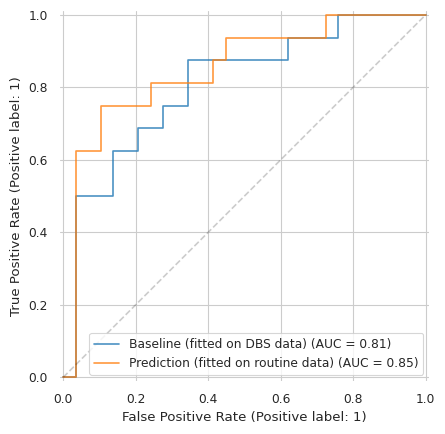

In [44]:
amp_expected_change = smf.logit(
    "improvement ~ z1 + z2", data=mu
).fit()

baseline_data = pd.DataFrame.from_dict(
    {
        "pre_pdq": X_uke[PDQ_COLUMNS].mean(axis=1),
        "updrs_iii_change": extra_data_uke["UPDRS III: Change"],
        "diagnosis_time": covariates_uke["Time since diagnosis"],
        "improvement": (X_uke[PDQ_COLUMNS].mean(axis=1) - y_uke[PDQ_COLUMNS].mean(axis=1) >= THRESHOLD).astype(float),
    }
)

custom_data = pd.concat((mu.drop(columns=["improvement"]), baseline_data), axis=1).dropna().astype(float)

baseline = smf.logit(
    "improvement ~ pre_pdq + updrs_iii_change + diagnosis_time", data=custom_data
).fit()

with sns.axes_style("whitegrid"):
    sns.set_context("paper")

    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        baseline.predict(custom_data),
        name="Baseline (fitted on DBS data)",
        alpha=0.8
    )
    
    viz = RocCurveDisplay.from_predictions(
        custom_data["improvement"],
        amp_expected_change.predict(custom_data),
        name="Prediction (fitted on routine data)",
        ax=viz.ax_,
        alpha=0.8
    )

    sns.despine(top=True, bottom=True, left=True, right=True)
    
    viz.ax_.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.2)